### 1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
columns = ['userid','prodid','ratings','timestamp']
electronic_df = pd.read_csv('ratings_Electronics.csv', names = columns)

In [4]:
electronic_df.head()

,userid,prodid,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


# IN the section below, we will check some characteristics of the dataset and plot charts for frequency distribution

In [5]:
electronic_df.shape

(7824482, 4)

In [6]:
### Above Data set has 7.8 MN records with each individual record defining rating for a product

In [7]:
electronic_df.dtypes

userid        object
prodid        object
ratings      float64
timestamp      int64
dtype: object

In [8]:
### Ratings and timestamps are numbers.
### We need to convert USERID and PRODID to Characters

In [9]:
electronic_df.userid=electronic_df.userid.astype(str)
electronic_df.prodid=electronic_df.prodid.astype(str)

In [10]:
## Check if there are datasets with missing values
electronic_df.isna().sum()

userid       0
prodid       0
ratings      0
timestamp    0
dtype: int64

In [11]:
# Dataset does not have any missing value

In [12]:
# Create frequency polts on Ratings to create a trend of ratings 

In [13]:
electronic_grp_df = pd.DataFrame(electronic_df['ratings'].value_counts())

In [14]:
electronic_grp_df.head()

,ratings
5.0,4347541
4.0,1485781
1.0,901765
3.0,633073
2.0,456322


<BarContainer object of 5 artists>

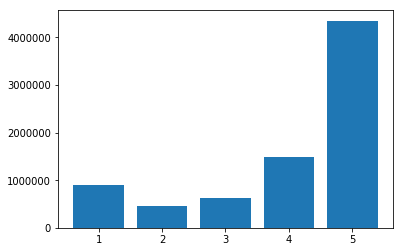

In [15]:
fig, ax = plt.subplots()
ax.bar(electronic_grp_df.index, electronic_grp_df.ratings)

In [16]:
# Total unique users 
print("Total unique users - ",len(electronic_df["userid"].unique()))

Total unique users -  4201696


### 2. Take subset of dataset to make it less sparse/more dense. 
### (For example, keep the users only who has given 50 or more number of ratings )

In [17]:
electronic_df.head()

,userid,prodid,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [18]:
counts = electronic_df['userid'].value_counts()

In [19]:
counts.dtypes

dtype('int64')

In [20]:
counts.describe()

count    4.201696e+06
mean     1.862220e+00
std      2.885110e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.200000e+02
Name: userid, dtype: float64

In [21]:
electronic_fil_df = electronic_df[electronic_df['userid'].isin(counts[counts>50].index)]

In [22]:
electronic_fil_df.head()

,userid,prodid,ratings,timestamp
118,AT09WGFUM934H,0594481813,3.0,1377907200
177,A32HSNCNPRUMTR,0970407998,1.0,1319673600
178,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
492,A3CLWR1UUZT6TG,0972683275,5.0,1373587200
631,A3TAS1AG6FMBQW,0972683275,5.0,1353456000


### 3. Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [23]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))

In [24]:
data = Dataset.load_from_df(electronic_fil_df[['userid', 'prodid', 'ratings']], reader)

In [25]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30,random_state=7)

### 4. Build Popularity Recommender model.

In [26]:
electronic_pop_df = electronic_fil_df

In [27]:
electronic_pop_df['avg_ratings'] = electronic_pop_df.groupby('prodid')['ratings'].transform('mean')

In [28]:
electronic_pop_df['cnt_ratings'] = electronic_pop_df.groupby('prodid')['ratings'].transform('count')

In [29]:
electronic_score_df = electronic_pop_df[["prodid","avg_ratings","cnt_ratings"]]

In [30]:
electronic_score_df.drop_duplicates(inplace = True)

In [31]:
electronic_score_df['score'] = electronic_score_df['avg_ratings'] * electronic_score_df['cnt_ratings']

In [32]:
### We have created a dataframe with unique products, their average ratings, their overall scoring count
### For the set we have calculated a weighted score basis Count and Mean
### Five or 10 Sorted measures should provide the most popular item rating

In [33]:
electronic_score_df.sort_values('score', ascending = False).head(10)

,prodid,avg_ratings,cnt_ratings,score
3313486,B003ES5ZUU,4.858757,177,860.0
6104981,B0088CJT4U,4.215686,204,860.0
1198226,B000N99BBC,4.773006,163,778.0
5941380,B007WTAJTO,4.692308,156,732.0
6031403,B00829TIEK,4.431507,146,647.0
6028195,B00829THK0,4.409091,132,582.0
6190152,B008DWCRQW,4.088889,135,552.0
4024382,B004CLYEDC,4.666667,117,546.0
2796338,B002R5AM7C,4.118110,127,523.0
3044121,B0034CL2ZI,4.628571,105,486.0


### 5. Build Collaborative Filtering model.

In [34]:
from surprise import SVD
from surprise import accuracy

In [35]:
svd_model = SVD(n_factors=100,biased=False)
svd_model.fit(trainset)

In [36]:
test_pred = svd_model.test(testset)

In [37]:
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 2.3038


2.3037630427413074

### 6. Evaluate both the models. (Once the model is trained on the training data, 
### it can be used to compute the error (RMSE) on predictions made on the test data.)

In [38]:
### in case of collaborative filtering, RMSE is generated based on predictions
### In Case of Popularity recommendations, there is no prediction but standard outcome
### Basis understanding of the two models, in the current form it is difficult to compare the models basis RMS

In [39]:
### Could not find recommender model ins Surprise package
### Turicreate library has popularity recommender model, however it is not compatible with P 3.7

### 7. Get top - K (K = 5) recommendations. Since our goal is to recommend 
### new products to each user based on his/her habits,we will recommend 5 new products.

In [40]:
from surprise import KNNWithMeans
from surprise import accuracy

In [41]:
algo = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [42]:
# user item rating data 
user_records = trainset.ur

In [43]:
trainset.to_raw_iid(200)

'B0096JZRBI'

In [44]:
innerid = trainset.to_inner_iid('B0096JZRBI')

In [45]:
for i in algo.get_neighbors(iid = innerid, k = 5):
    print(trainset.to_raw_iid(i))

B004QK8FBG
B00834SJNA
B003LSTD38
B000WY8JRU
B002VPE1YS


### 8. Summarise your insights.

In [46]:
### Predictions done using collaborative filtering model
# B004QK8FBG
# B00834SJNA
# B003LSTD38
# B000WY8JRU
# B002VPE1YS

In [47]:
### Predictions done using popularity recommender model
# B003ES5ZUU
# B0088CJT4U
# B000N99BBC
# B007WTAJTO
# B00829TIEK

In [48]:
# Two recommendations are completely different category
# The popularity recommendation is purely based on maximum ratings and weighted score
# Collaborative recommendation is purely based on nearness to the item associated with the product
# This is basis users who have bought similar product and what has been their additional product rating pattern